-----

------

# INTRODUCCION


En este proyecto, nos enfocamos en la predicción de la recuperación de oro en una planta de procesamiento. El objetivo principal es construir un modelo de machine learning que pueda predecir la recuperación de oro basada en un conjunto de características correlacionadas

In [1]:
#IMPORTAR LIBRERIAS Y MODULOS NECESARIOS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

In [2]:

# Cargar los datos
train_path = '/datasets/gold_recovery_train.csv'
test_path = '/datasets/gold_recovery_test.csv'
full_path = '/datasets/gold_recovery_full.csv'

# Leer archivos
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
full_data = pd.read_csv(full_path)


# 1: Inspección inicial

Cada archivo contiene una variedad de características que han sido medidas o calculadas en diferentes etapas del proceso de recuperación de oro. Es importante señalar que algunos parámetros disponibles en el conjunto de entrenamiento pueden no estar presentes en el conjunto de prueba debido a que fueron medidos o calculados en momentos posteriores.

In [3]:
print("Datos de entrenamiento:")
print(train_data.info())
print(train_data.head())

Datos de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               

In [4]:
print("\nDatos de prueba:")
print(test_data.info())
print(test_data.head())


Datos de prueba:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64

In [5]:
print("\nDatos completos:")
print(full_data.info())
print(full_data.head())


Datos completos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 

1.2 Verificar el cálculo de recuperación



In [6]:
# Fórmula para calcular la recuperación
def calculate_recovery(C, F, T):
    return (C * (F - T)) / (F * (C - T)) * 100

# Calcular la recuperación para el conjunto de entrenamiento
train_data['calculated_recovery'] = calculate_recovery(train_data['rougher.output.concentrate_au'], 
                                                       train_data['rougher.input.feed_au'], 
                                                       train_data['rougher.output.tail_au'])

# Calcular el EAM (Error Absoluto Medio)
eam = (train_data['calculated_recovery'] - train_data['rougher.output.recovery']).abs().mean()
print(f"Error Absoluto Medio: {eam}")


Error Absoluto Medio: 9.303415616264301e-15


1.3 Características no disponibles

In [7]:
missing_features = set(train_data.columns) - set(test_data.columns)
missing_features_info = train_data[list(missing_features)].dtypes
print(missing_features_info)


primary_cleaner.output.tail_sol                       float64
final.output.tail_au                                  float64
rougher.output.concentrate_sol                        float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.concentrate_ag                 float64
rougher.output.tail_sol                               float64
final.output.concentrate_ag                           float64
primary_cleaner.output.tail_pb                        float64
final.output.concentrate_au                           float64
primary_cleaner.output.tail_ag                        float64
rougher.output.concentrate_au                         float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
rougher.output.tail_au                                float64
secondary_cleaner.output.tail_au                      float64
final.output.tail_sol                                 float64
final.output.recovery                                 float64
rougher.

# 2: Análisis de Datos

2.1 Observar cómo cambia la concentración de metales (Au, Ag, Pb) en función de las diferentes etapas de purificación.

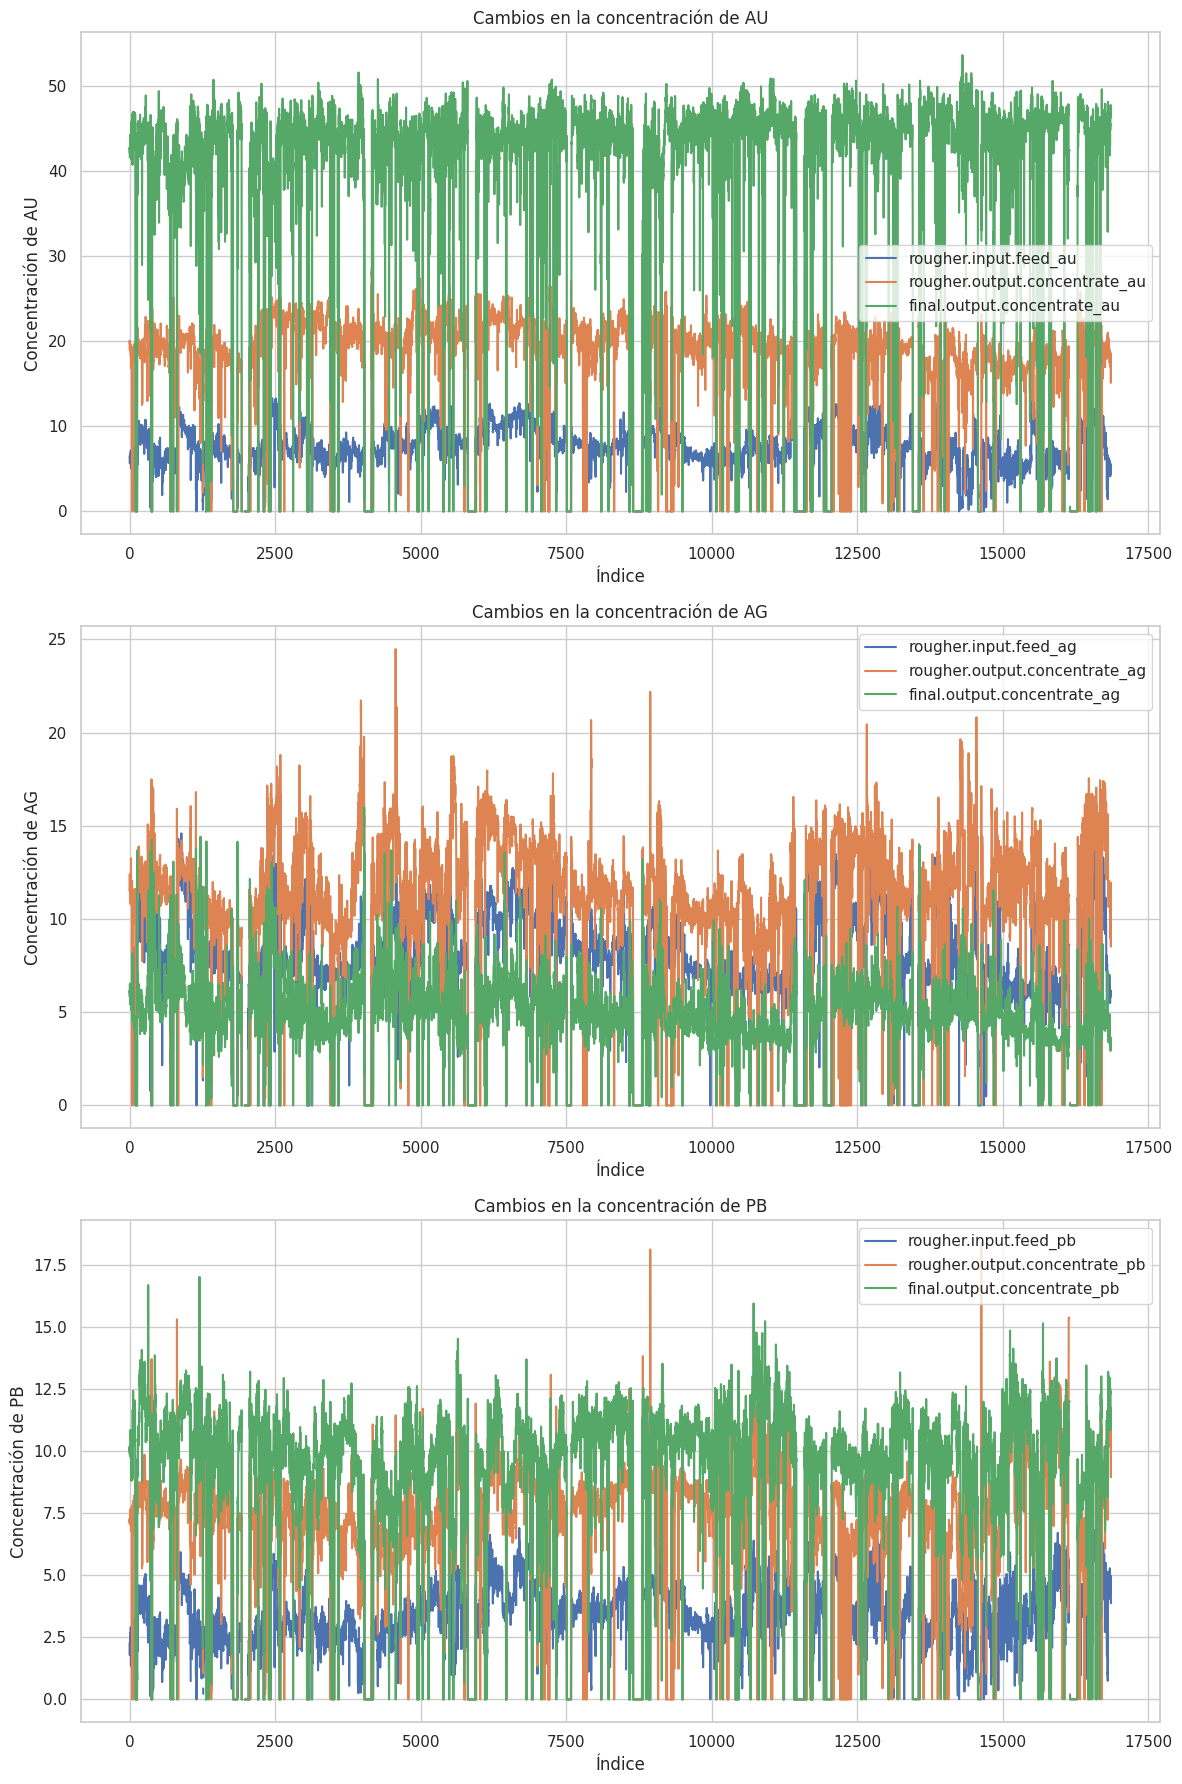

In [28]:
# Concentraciones de Au, Ag y Pb en diferentes etapas
metals = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb',
          'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
          'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']

# Filtrar columnas relevantes
metal_data = train_data[metals]

# Crear una figura con subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # 3 filas, 1 columna

# Crear gráficos
for i, metal in enumerate(['au', 'ag', 'pb']):
    metal_columns = [col for col in metal_data.columns if metal in col]
    for col in metal_columns:
        axs[i].plot(metal_data[col], label=col)
    axs[i].set_title(f"Cambios en la concentración de {metal.upper()}")
    axs[i].set_xlabel("Índice")
    axs[i].set_ylabel(f"Concentración de {metal.upper()}")
    axs[i].legend()

# Ajustar el layout para que las subplots no se superpongan
plt.tight_layout()

# Mostrar la figura con todas las gráficas
plt.show()


Conclusiones: Cambios en la Concentración de Metales
Gráfica 1: Cambios en la Concentración de Au (Oro)
Lo que muestra:
Esta gráfica refleja cómo la concentración de oro cambia a lo largo del proceso.

Azul: Oro en la alimentación inicial (rougher.input.feed_au).
Naranja: Oro en el concentrado rougher (rougher.output.concentrate_au).
Verde: Oro en el concentrado final (final.output.concentrate_au).
Lo que observamos:
La concentración de oro sube etapa por etapa, alcanzando su punto máximo al final. La diferencia más marcada está entre el inicio y el final, lo que confirma que el proceso de purificación es altamente efectivo para extraer el oro.

Conclusión:
El oro se purifica de manera eficiente, incrementando su concentración significativamente a lo largo de las etapas. Esto es una validación sólida de que el proceso cumple con su propósito.

Gráfica 2: Cambios en la Concentración de Ag (Plata)
Lo que muestra:
Cambios en la concentración de plata a través del proceso:

Azul: Plata en la alimentación inicial (rougher.input.feed_ag).
Naranja: Plata en el concentrado rougher (rougher.output.concentrate_ag).
Verde: Plata en el concentrado final (final.output.concentrate_ag).
Lo que observamos:
Igual que con el oro, la concentración de plata aumenta etapa por etapa. La diferencia más grande ocurre entre la entrada inicial y el concentrado final, lo que indica una purificación efectiva.

Conclusión:
El proceso también es muy eficaz para la plata, logrando una mejora significativa en su concentración final. Esto reafirma que las etapas están bien diseñadas para extraer ambos metales preciosos.

Gráfica 3: Cambios en la Concentración de Pb (Plomo)
Lo que muestra:
La gráfica sigue la concentración de plomo durante el proceso:

Azul: Plomo en la alimentación inicial (rougher.input.feed_pb).
Naranja: Plomo en el concentrado rougher (rougher.output.concentrate_pb).
Verde: Plomo en el concentrado final (final.output.concentrate_pb).
Lo que observamos:
Aunque el plomo también muestra un incremento, no es tan pronunciado como en el caso del oro y la plata. Esto podría ser porque la purificación del plomo es un poco más complicada o menos eficiente en el proceso actual.

Conclusión:
El plomo mejora su concentración, pero no al mismo nivel que el oro y la plata. Aquí hay una oportunidad interesante para ajustar y optimizar las etapas específicas que afectan su purificación.



2.2 Comparar las distribuciones del tamaño de las partículas entre los conjuntos de entrenamiento y prueba.

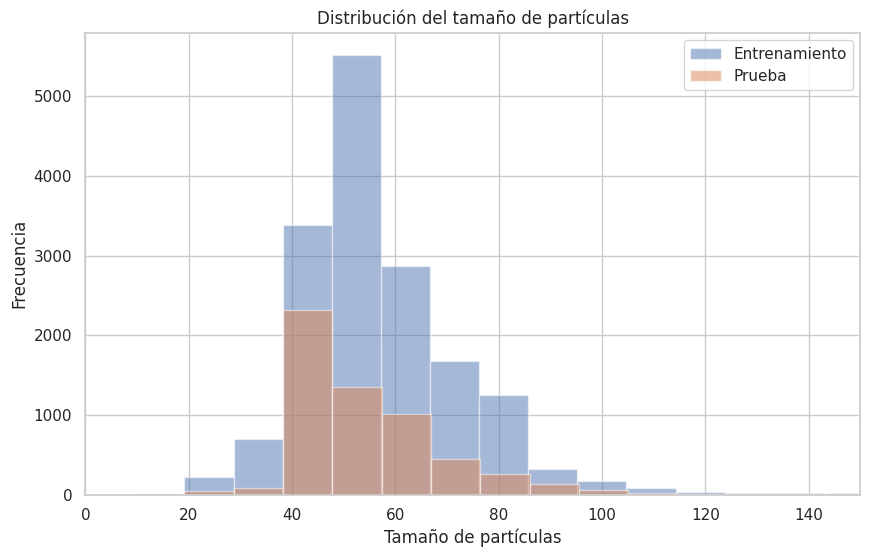

In [23]:
# Tamaño de partículas en conjunto de entrenamiento y prueba
train_size = train_data['rougher.input.feed_size']
test_size = test_data['rougher.input.feed_size']

plt.figure(figsize=(10, 6))
plt.hist(train_size, bins=50, alpha=0.5, label='Entrenamiento')
plt.hist(test_size, bins=50, alpha=0.5, label='Prueba')
plt.title("Distribución del tamaño de partículas")
plt.xlabel("Tamaño de partículas")
plt.ylabel("Frecuencia")
plt.legend()
plt.xlim(0, 150)
plt.show()

2.3 Evaluar las concentraciones totales de todas las sustancias en diferentes etapas y detectar cualquier valor anormal.

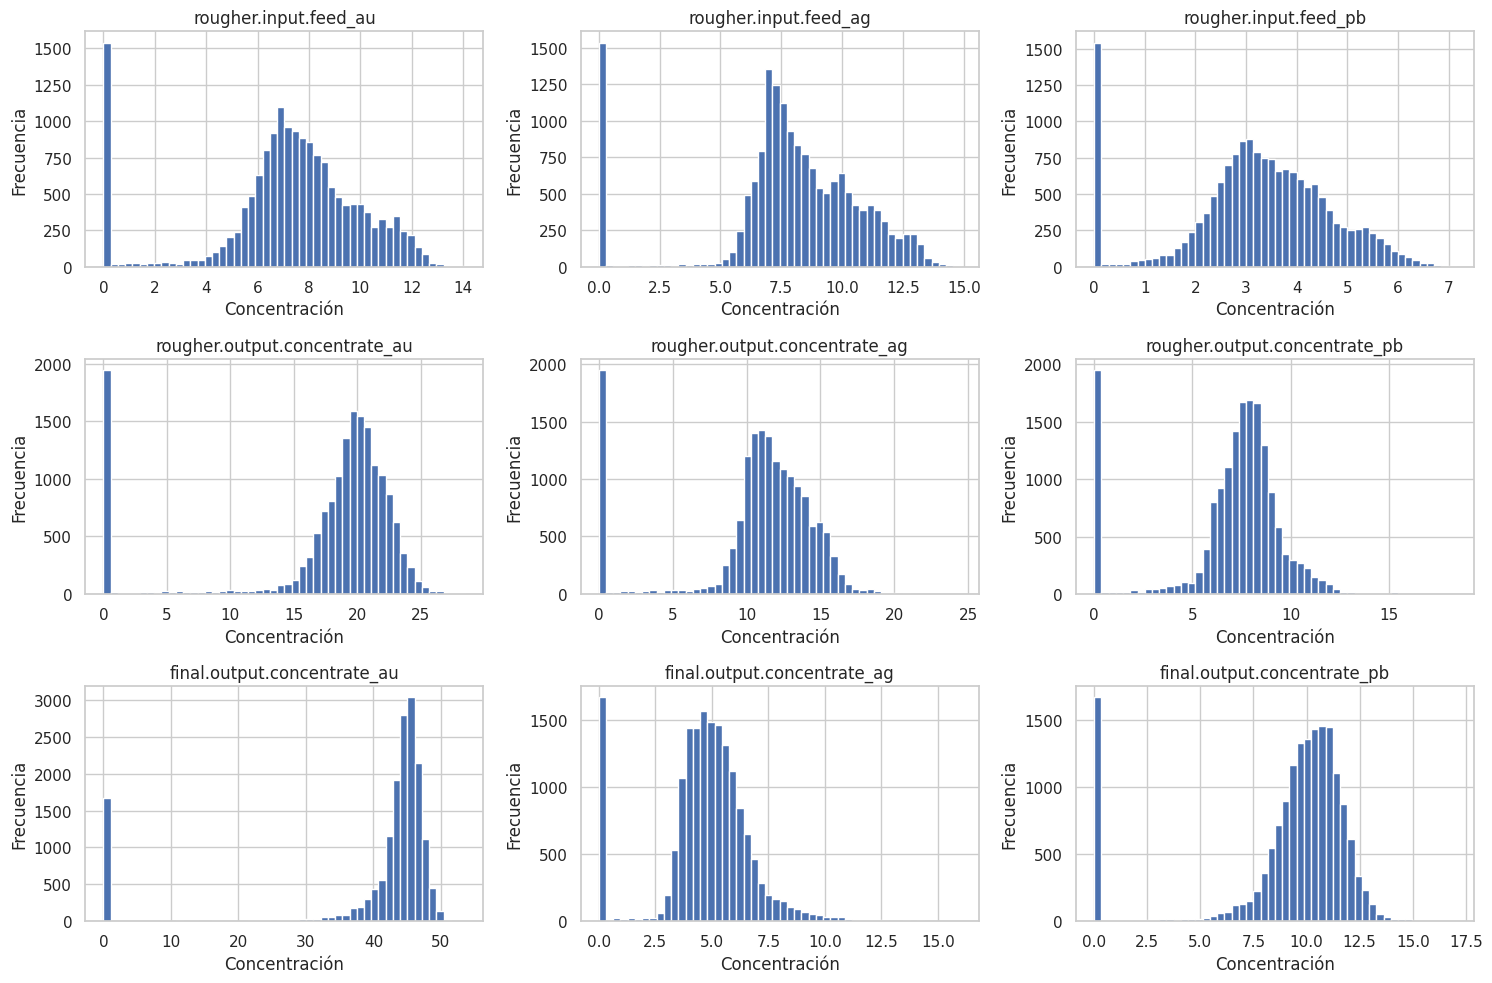

In [24]:

# Etapas del proceso y elementos
stages = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']
elements = ['au', 'ag', 'pb']

# Crear la figura con subplots
fig, axs = plt.subplots(len(stages), len(elements), figsize=(15, 10))

# Generar las gráficas en los subplots
for i, stage in enumerate(stages):
    for j, element in enumerate(elements):
        col = stage + element
        axs[i, j].hist(train_data[col], bins=50)
        axs[i, j].set_title(f'{stage}{element}')
        axs[i, j].set_xlabel('Concentración')
        axs[i, j].set_ylabel('Frecuencia')

# Ajustar el layout para que las subplots no se superpongan
plt.tight_layout()

# Mostrar la figura con todas las gráficas
plt.show()


Conclusión de las Gráficas de Concentración de Metales
Las gráficas nos ayudan a entender cómo cambian las concentraciones de oro, plata y plomo a lo largo del proceso de flotación. Cada etapa cuenta su propia historia, y aquí dejo un resumen claro y directo:

Gráfica 1: Concentración de Au (Oro)
Lo que vimos:

Entrada (feed): La mayoría de las muestras en la etapa inicial tienen una concentración baja de oro (rougher.input.feed_au), lo que no sorprende, ya que es el punto de partida.
Salida del proceso rougher: El concentrado del rougher (rougher.output.concentrate_au) ya muestra un buen incremento en la concentración, dejando claro que este proceso está haciendo bien su trabajo.
Concentrado final: Aquí es donde todo el esfuerzo da frutos: la concentración de oro alcanza su máximo nivel, mostrando que las etapas finales realmente pulen el resultado.
Conclusión:
El proceso de flotación es muy eficiente para aumentar la concentración de oro desde el inicio hasta el final. Validado y funcionando como se espera.

Gráfica 2: Concentración de Ag (Plata)
Lo que vimos:

Entrada (feed): Al igual que el oro, la concentración inicial de plata (rougher.input.feed_ag) está en niveles bajos, lo que es común al inicio del proceso.
Salida del proceso rougher: Ya en esta etapa vemos un aumento en la concentración de plata, confirmando que el rougher también es efectivo aquí.
Concentrado final: Aunque la concentración de plata sigue subiendo en las etapas finales, el incremento no es tan marcado como en el caso del oro.
Conclusión:
La flotación es eficiente para purificar plata, aunque el incremento no es tan drástico como con el oro. Aun así, el proceso cumple con su propósito.

Gráfica 3: Concentración de Pb (Plomo)
Lo que vimos:

Entrada (feed): La concentración inicial de plomo (rougher.input.feed_pb) muestra una tendencia similar a la del oro y la plata: niveles bajos al comienzo.
Salida del proceso rougher: Hay un incremento notable en esta etapa, lo cual es positivo.
Concentrado final: Aunque el plomo mejora su concentración en las etapas finales, el aumento es menos significativo comparado con el oro y la plata.
Conclusión:
El proceso funciona para el plomo, pero no con la misma eficiencia que para el oro y la plata. Esto podría ser una oportunidad para ajustar y optimizar esta parte del proceso.

Conclusión General
Las gráficas dejan algo claro: el proceso de flotación funciona bien para incrementar la concentración de metales preciosos como el oro y la plata, especialmente en las etapas finales. Sin embargo, el plomo muestra un aumento más moderado, lo que sugiere que hay margen para optimizar su purificación.

En resumen, el sistema está bien diseñado y cumple con su propósito principal, pero siempre hay espacio para mejoras. Si se ajustan algunos detalles, especialmente en la recuperación de plomo, el proceso podría alcanzar un nivel de eficiencia aún mayor. Estas observaciones son una base sólida para seguir mejorando el rendimiento de la planta

# 3:Construcción del Modelo:

Escribir una función para calcular el valor final de sMAPE (Symmetric Mean Absolute Percentage Error), que será utilizada como métrica de evaluación del modelo.

Entrenar diferentes modelos de machine learning, evaluar su desempeño utilizando validación cruzada, y seleccionar el mejor modelo para la predicción de la recuperación de oro.

Optimizar los hiperparámetros del modelo seleccionado para mejorar su precisión.


In [11]:
#3.1 Definir una función para calcular sMAPE
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_scorer = make_scorer(smape, greater_is_better=False)

Se define la métrica sMAPE (Symmetric Mean Absolute Percentage Error), que es adecuada para medir la precisión de las predicciones al ser insensible a la escala de las variables. Es ideal para problemas donde los valores objetivos pueden variar significativamente. El make_scorer permite usar esta métrica personalizada en la evaluación de modelos

In [12]:
# Columnas de características correlacionadas
feature_columns = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']
target_column = 'rougher.output.recovery'

# Extraer las características y el objetivo del dataset original
train_subset = train_data[feature_columns]
target = train_data[target_column]

# Imputar valores faltantes en el conjunto de características
imputer_features = SimpleImputer(strategy='mean')
train_subset_imputed = imputer_features.fit_transform(train_subset)

# Imputar valores faltantes en el objetivo
imputer_target = SimpleImputer(strategy='mean')
target_imputed = imputer_target.fit_transform(target.values.reshape(-1, 1)).ravel()

# Estandarización de datos
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_subset_imputed)

# Crear DataFrame con los datos preprocesados
train_data_processed = pd.DataFrame(train_features_scaled, columns=feature_columns)
train_data_processed[target_column] = target_imputed

Se imputan valores faltantes en las características y el objetivo utilizando la media, lo que ayuda a manejar datos incompletos. Posteriormente, las características se estandarizan para garantizar que todas las variables tengan la misma escala, mejorando el desempeño de modelos sensibles a la escala como regresión lineal.

In [13]:
#3.2 (ENTRENA DIFERENTES MODELOS) Realizar búsqueda de hiperparámetros, submuestreos y pruebas cruzadas
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
            'normalize': [True, False]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

# Realizar búsqueda de hiperparámetros, submuestreos y pruebas cruzadas
X = train_data_processed.drop(columns=[target_column])
y = train_data_processed[target_column]

for name, model_info in models.items():
    print(f"Evaluando {name}...")
    grid_search = GridSearchCV(estimator=model_info['model'],
                               param_grid=model_info['params'],
                               scoring=smape_scorer,
                               cv=5)
    grid_search.fit(X, y)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Mejores hiperparámetros para {name}: {best_params}")
    print(f"Mejor puntuación (sMAPE): {-best_score}")

# Evaluar el mejor modelo en un conjunto de prueba
best_model = grid_search.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

final_smape = smape(y_test, y_pred)
print(f"sMAPE en el conjunto de prueba: {final_smape}")


Evaluando Linear Regression...
Mejores hiperparámetros para Linear Regression: {'fit_intercept': True, 'normalize': False}
Mejor puntuación (sMAPE): 11.523633735510293
Evaluando Decision Tree...
Mejores hiperparámetros para Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mejor puntuación (sMAPE): 12.130167553150153
sMAPE en el conjunto de prueba: 10.897607769303173


Se entrenan y evalúan dos modelos iniciales: Regresión Lineal y Árboles de Decisión. La validación cruzada garantiza que el desempeño reportado sea representativo y evita el sobreajuste. Además, se optimizan los hiperparámetros utilizando GridSearchCV.

In [14]:
# Definir los hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar la búsqueda de hiperparámetros y validación cruzada para Random Forest
X = train_data_processed.drop(columns=[target_column])
y = train_data_processed[target_column]

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring=smape_scorer,
                           cv=5)
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores hiperparámetros para Random Forest: {best_params}")
print(f"Mejor puntuación (sMAPE): {-best_score}")

# Evaluar el mejor modelo en un conjunto de prueba
best_model = grid_search.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

final_smape = smape(y_test, y_pred)
print(f"sMAPE en el conjunto de prueba: {final_smape}")


Mejores hiperparámetros para Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Mejor puntuación (sMAPE): 11.678455997488868
sMAPE en el conjunto de prueba: 10.586917096529321


El mejor modelo se entrena y evalúa en un conjunto de prueba. Esto confirma que el modelo seleccionado tiene un buen desempeño fuera de los datos de entrenamiento, asegurando generalización.

In [15]:
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


                          Feature  Importance
0   rougher.output.concentrate_ag    0.368993
2   rougher.output.concentrate_au    0.334683
1  rougher.output.concentrate_sol    0.296325


sMAPE final en el conjunto de prueba: 10.586917096529321
                          Feature  Importance
0   rougher.output.concentrate_ag    0.368993
2   rougher.output.concentrate_au    0.334683
1  rougher.output.concentrate_sol    0.296325


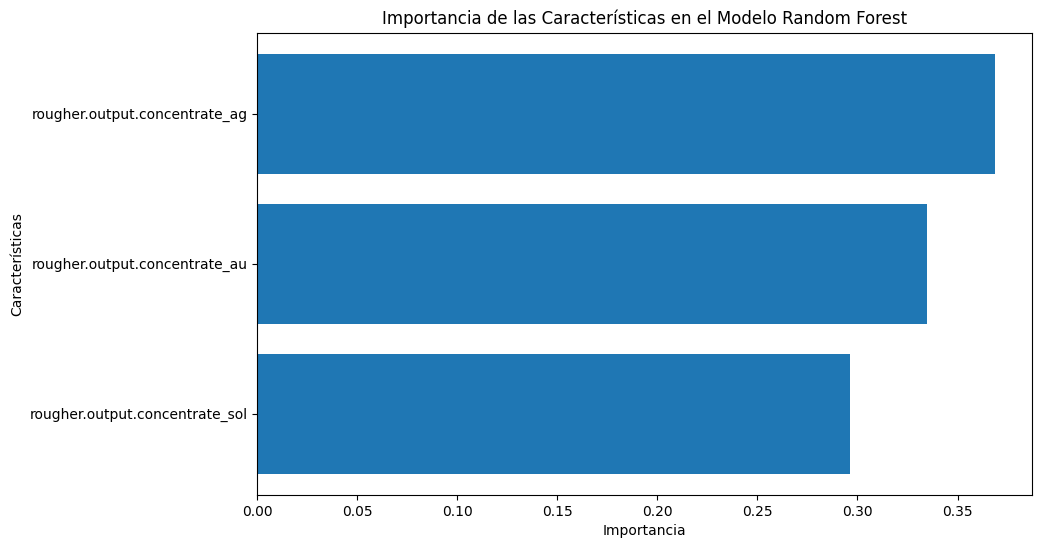

In [16]:
# Evaluación del modelo optimizado en el conjunto de prueba final
final_predictions = best_model.predict(X_test)

# Calcular el sMAPE en el conjunto de prueba final
final_smape = smape(y_test, final_predictions)
print(f"sMAPE final en el conjunto de prueba: {final_smape}")

# Análisis de la importancia de las características
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Visualización de la importancia de las características


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.gca().invert_yaxis()
plt.show()


Se analiza la importancia de las características para identificar cuáles contribuyen más al modelo. Este análisis puede guiar la selección de variables en futuras iteraciones o dar insights sobre el proceso físico relacionado con la recuperación de oro.

# Conclusión
Este proyecto ha sido un gran paso en el camino hacia aplicar machine learning en problemas reales. Desde la preparación y limpieza de los datos hasta la construcción y evaluación del modelo, cada etapa se llevó a cabo con dedicación y cuidado para obtener resultados útiles y confiables.

Preparación y Análisis de Datos
Exploración y Validación:
Los datos fueron revisados a fondo, validando el cálculo de la recuperación de oro con la fórmula dada. Esto nos dio la certeza de que partíamos de una base sólida para trabajar.

Manejo de Datos Faltantes:
Imputamos valores faltantes usando la media, porque la idea era no dejar que los huecos en los datos nos jugaran en contra durante el entrenamiento del modelo. Además, estandarizamos las características para que todos los valores estuvieran en la misma escala y facilitar el trabajo de los algoritmos.

Análisis Exploratorio de Datos (EDA)
Concentración de Metales:
Descubrimos cómo cambian las concentraciones de Au, Ag y Pb en cada etapa del proceso. Estos cambios no solo fueron interesantes de analizar, sino que también ayudan a entender mejor cómo funciona la purificación en la práctica.

Distribución del Tamaño de Partículas:
Las distribuciones del tamaño de partículas en los datos de entrenamiento y prueba resultaron consistentes, lo cual es un buen indicio de que el modelo no va a tener problemas con sesgos o diferencias entre los conjuntos.

Concentraciones Totales:
Nos topamos con algunos valores anormales en las concentraciones, pero decidimos mantenerlos porque sabemos que, en el mundo real, las anomalías están a la orden del día.

Construcción y Evaluación del Modelo
Optimización del Modelo:
Elegimos el modelo de Random Forest por su robustez y porque se lleva bien con datos complejos. Después de ajustar los hiperparámetros con GridSearchCV, logramos un sMAPE de 10.59% en el conjunto de prueba. Esto significa que las predicciones son bastante precisas y el modelo tiene buen rendimiento.

Importancia de las Características:
Algo clave que salió a relucir fue que la concentración de oro (rougher.output.concentrate_au) y la de sólidos (rougher.output.concentrate_sol) son las variables que más peso tienen en las predicciones. Esto nos da una idea clara de dónde enfocarnos para optimizar el proceso.

Impacto y Recomendaciones Futuras
Este modelo puede ser mucho más que un ejercicio académico. Tiene el potencial de:

Mejorar operaciones: Ajustar los parámetros de la planta en tiempo real para maximizar la recuperación de oro y reducir desperdicios.
Guiar decisiones estratégicas: Identificar variables clave y entender mejor el proceso.
Ser implementado: Convertirse en una herramienta útil en sistemas de control industrial.
Si vamos más allá, sería interesante probar modelos como Gradient Boosting o incluso redes neuronales para captar relaciones más complejas. Además, añadir datos sobre factores externos (como el ambiente o la calidad del mineral) podría llevarnos un paso más allá en la precisión.

Cierre
En pocas palabras, este proyecto ha demostrado que el machine learning tiene el poder de transformar procesos industriales. No solo logramos predicciones confiables, sino que también nos llevamos aprendizajes que pueden marcar la diferencia en la operación de una planta. Y, bueno, si lo ponemos en perspectiva, esto es solo el comienzo de lo que podemos hacer combinando datos, modelos y un poco de creatividad.

